In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

#Dataset

- https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz

In [2]:
if not os.path.exists("tiny_nerf_data.npz"):
  !wget https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz

dataset = np.load("tiny_nerf_data.npz")
print("Tiny NeRF Data")

print("list of files:", dataset.files)

print("shape of 'images:'", dataset["images"].shape)
# 100 X 100 크기의 106개의 이미지 (RGB 3 channel)

print("shape of 'poses:'", dataset["poses"].shape)
# Extrinsic parameters
# 카메라가 world coordinate의 기준점으로부터 얼마나 rotated 되고 translated 되었는지

print("focal:", dataset["focal"])
# Intrinsic parameter

--2023-02-28 09:14:40--  https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://bmild.com/nerf/tiny_nerf_data.npz [following]
--2023-02-28 09:14:40--  https://bmild.com/nerf/tiny_nerf_data.npz
Resolving bmild.com (bmild.com)... 216.239.38.21, 216.239.34.21, 216.239.36.21, ...
Connecting to bmild.com (bmild.com)|216.239.38.21|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bmild.github.io/nerf/tiny_nerf_data.npz [following]
--2023-02-28 09:14:40--  https://bmild.github.io/nerf/tiny_nerf_data.npz
Resolving bmild.github.io (bmild.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to bmild.github.io (bmild.github.io)|185.199.108.153|:443... connected.
HTTP re

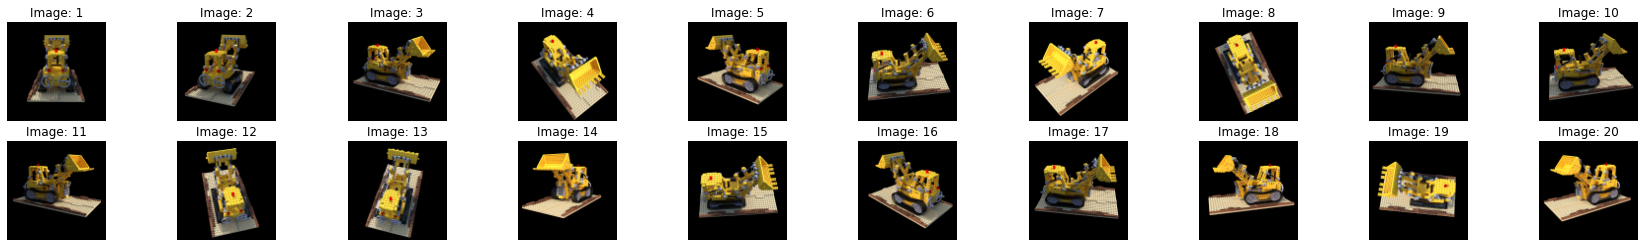

In [3]:
fig, axs = plt.subplots(nrows=2, ncols=10, figsize=(30, 4))

for idx, ax in enumerate(axs.flatten()):
  plt.sca(ax)
  plt.imshow(dataset['images'][idx])
  plt.title('Image: {}'.format(idx+1))
  plt.axis("off")

# Pinhole Camera Model

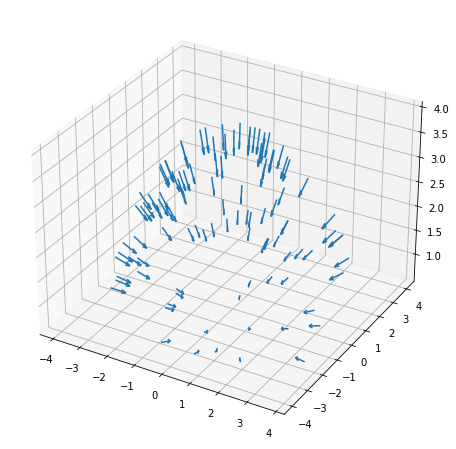

In [4]:
poses = dataset['poses']
dirs = np.stack([np.sum([0, 0, -1] * pose[:3, :3], axis=-1) for pose in poses])
# Camera coordinate의 z축과 camera rotation을 곱해주면 camear coordinate의 z축을 camera rotation 방향으로 align 시킨다.
origins = poses[:, :3, 3]
# Camera coordinate의 기준점이 coordinate의 기준점으로부터 얼마나 떨어져 있는지 (camera translation)

ax = plt.figure(figsize=(12,8)).add_subplot(projection="3d")
# Quiver: 2차원원 평면상에 각각 좌표에서의 direction 그려주는 utility
_ = ax.quiver(
    origins[..., 0].flatten(),  
    origins[..., 1].flatten(),
    origins[..., 2].flatten(),
    dirs[..., 0].flatten(),
    dirs[..., 1].flatten(),
    dirs[..., 2].flatten(),
    length=0.5,
    normalize=True
)
plt.show()

# Utilites

In [5]:
# 하나의 image에에 관해 각각의 모든든 픽셀을 지나는 ray의 origin과 viewing direction
def get_rays(h: int, w: int, focal_length: float, pose: torch.Tensor):
  # Pixel coordinate
  i, j = torch.meshgrid(
      torch.arange(w, dtype=torch.float32).to(pose),
      torch.arange(h, dtype=torch.float32).to(pose),
      indexing='ij')

  i, j = i.transpose(-1, -2), j.transpose(-1, -2)
  # Pixel coordinate에서의 각각의 픽셀이 이미지의 중점(w와 h의 각각의 2분의 1)으로부터 얼마나 떨어져 있는지
  rays_d = torch.stack([(i - w * .5) / focal_length, 
                        -(j - h * .5) / focal_length, 
                        -torch.ones_like(i)
                        ], dim=-1)
  rays_d = torch.sum(rays_d[..., np.newaxis, :] * pose[:3,:3], dim=-1)
  rays_o = pose[:3,-1].expand(rays_d.shape)
  return rays_o, rays_d

In [6]:
def stratified_sampling(
    rays_o, # rays_o shape: (width, height, 3)
            # 각각의 픽셀 좌표들이 실제 world coordinate 3차원 상에서 어떠한한 좌표를 지니는지
    rays_d, 
    near, # lower bound
    far, # upper bound
    n
  ):

  t = torch.linspace(near, far, n).to(rays_o)

  # noise shape: (width, height, num_samples)
  noise_shape = list(rays_o.shape[:-1]) + [n]

  # depth values shape: (num_samples)
  # 앞의 항이 noise에 대응된다.
  t = torch.rand(noise_shape).to(rays_o) * (far - near) / n + t


  # (width, height, num_samples, 3) = (width, height, 1, 3) + (width, height, 1, 3) * (num_samples, 1)
  x = rays_o[..., np.newaxis, :] + rays_d[..., np.newaxis, :] * t[..., :, np.newaxis]

  return x, t

In [7]:
def positional_encoding(
    x, L=6, include_input=True
) -> torch.Tensor:
  encoding = [x] if include_input else []
  frequency_bands = 2.0 ** torch.linspace(
      0.0,
      L - 1,
      L,
      dtype=x.dtype,
      device=x.device,
  )
  for freq in frequency_bands:
    encoding.append(torch.sin(x * freq * np.pi))
    encoding.append(torch.cos(x * freq * np.pi))

  return torch.cat(encoding, dim=-1)

In [8]:
def volume_rendering(c, sigma, rays_o, t):
  sigma = torch.nn.functional.relu(sigma)[...,0]
  c = torch.sigmoid(c)
  # 인접한 point들끼리의 거리 차이
  delta = t[..., 1:] - t[..., :-1]
  # delta shape: (num_samples - 1)
  # 마지막 point에서 ray가 종료되었음을 알려준다.
  delta = torch.cat([delta, 
                     torch.tensor([1e10], dtype=rays_o.dtype, device=rays_o.device).expand(t[...,:1].shape)
                     ], dim=-1)
  
  alpha = 1. - torch.exp(-sigma * delta)
  T = torch.cumprod(1. - alpha + 1e-10, -1)
  # i번째 T는 i-1번째까지의 sample point 값들에 관해 누적하여 계산한 것이므로 한 칸을 민다.
  T = torch.roll(T, 1, -1)
  T[..., 0] = 1.

  w = T * alpha

  rgb = (w[..., np.newaxis] * c).sum(dim=-2)
  return rgb

In [9]:
class NeRF(torch.nn.Module):
  # x의 dimension이 어떻게 60일 수 있는지?
  # x는 3차원 데이터이지만, 앞서 정의한 positional encoding에 의해 sin, cos에서 L개의 각기 다른 주파수를 지니므로 3 * 2 * L에 의해 결정된 차원이다.
  # 여기서는 x에 대한 L을 10으로 처리한 것
  def __init__(self, gamma_x_dim=60, gamma_d_dim=24, num_channels=256, num_layers=8, skip=4):
    super(NeRF, self).__init__()

    self.layers = []

    for i in range(num_layers):
      if not i == skip:
        if i == 0:
          self.layers.append(torch.nn.Linear(gamma_x_dim, num_channels))
        else:
          self.layers.append(torch.nn.Linear(num_channels, num_channels))
      else:
        self.layers.append(torch.nn.Linear(num_channels + gamma_x_dim, num_channels))

    self.layers = torch.nn.ModuleList(self.layers)
    self.sigma_out = torch.nn.Linear(num_channels, 1)
    
    self.feature = torch.nn.Linear(num_channels, num_channels)
    self.branch = torch.nn.Linear(num_channels + gamma_d_dim, num_channels // 2)
    self.rgb_out = torch.nn.Linear(num_channels // 2, 3)

    self.skip = skip
    self.relu = torch.nn.functional.relu

  def forward(self, x, d):
    out = x

    for i, l in enumerate(self.layers):
      if not i == self.skip:
        out = self.relu(self.layers[i](out))
      else:
        out = torch.concat([out, x], dim=-1)
        out = self.relu(self.layers[i](out))

    sigma = self.sigma_out(out)

    out = self.feature(out)
    out = torch.concat([out, d], dim=-1)
    out = self.relu(self.branch(out))
    color = self.rgb_out(out)

    return color, sigma

# Training

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

images = dataset["images"]
poses = dataset["poses"]
focal_length = dataset["focal"]

num_images, h, w = images.shape[:3]

test_idx = 101
test_image = images[test_idx]
test_pose = poses[test_idx]

images = torch.from_numpy(images[:100, ..., :3]).to(device)
poses = torch.from_numpy(poses).to(device)
focal_length = torch.from_numpy(focal_length).to(device)

In [11]:
L_x = 10
L_d = 4

N_c = 32
 
lr = 5e-4
num_iters = 10000
num_channels = 128
num_layers = 8
skip = 4

display_every_iter = 1000

near = 2.
far = 6.

batch_size = 4 * 1024
include_input = False

In [12]:
def train_step(h, w, focal_length, pose, near, far, n_c, L_x, L_d):
  
  rays_o, rays_d = get_rays(h, w, focal_length, pose)
  x, t = stratified_sampling(rays_o, rays_d, near, far, n_c)

  # x shape: (width, height, n_c, 3) → (width * height * n_c, 3)
  x_flatten = x.reshape(-1, 3)
  d_flatten = rays_d[..., np.newaxis, :].expand_as(x).reshape(-1, 3)

  gamma_x = positional_encoding(x_flatten, L_x, include_input=include_input)
  gamma_d = positional_encoding(d_flatten, L_d, include_input=include_input)

  pred = []
  for i in range(0, gamma_x.shape[0], batch_size):
    pred.append(model(gamma_x[i:i+batch_size], gamma_d[i:i+batch_size]))

  colors = torch.concat([p[0] for p in pred], dim=0).reshape(h, w, -1, 3)
  sigma = torch.concat([p[1] for p in pred], dim=0).reshape(h, w, -1, 1)

  rgb = volume_rendering(colors, sigma, rays_o, t)
  return rgb

  0%|          | 0/10000 [00:03<?, ?it/s, loss=0.0597]

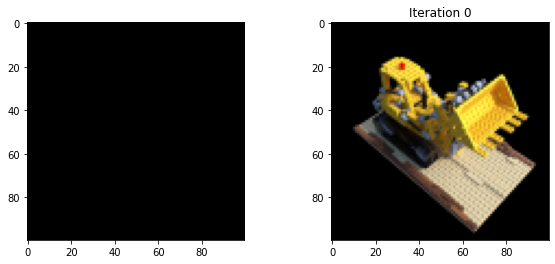

 10%|█         | 1000/10000 [03:26<30:26,  4.93it/s, loss=0.0601]

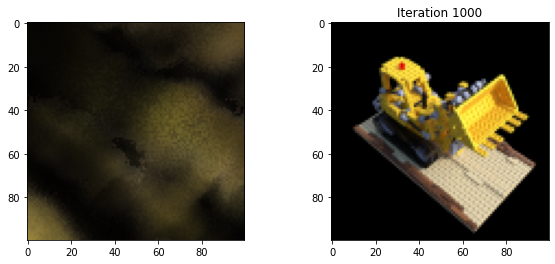

 20%|██        | 2000/10000 [06:49<27:03,  4.93it/s, loss=0.0574]

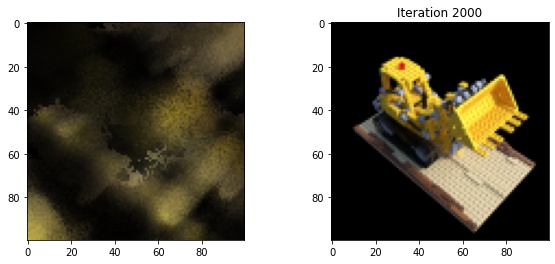

 30%|███       | 3000/10000 [10:12<23:54,  4.88it/s, loss=0.0608]

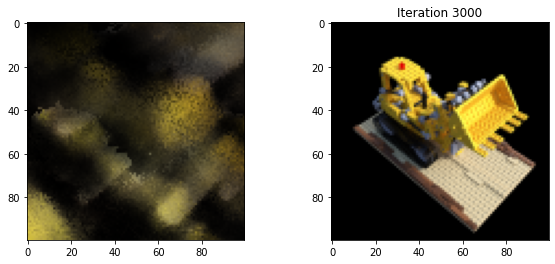

 40%|████      | 4000/10000 [13:36<20:29,  4.88it/s, loss=0.0287]

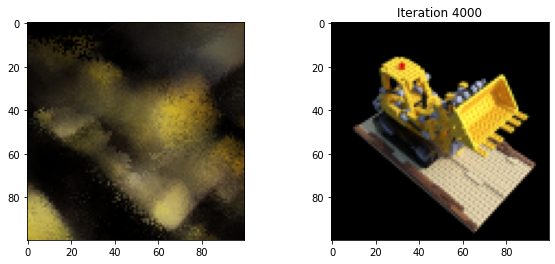

 50%|█████     | 5000/10000 [17:00<17:00,  4.90it/s, loss=0.0179]

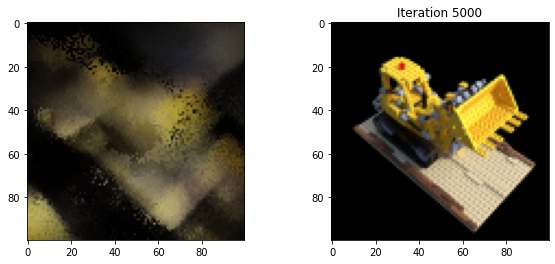

 60%|██████    | 6000/10000 [20:26<13:35,  4.90it/s, loss=0.0221]

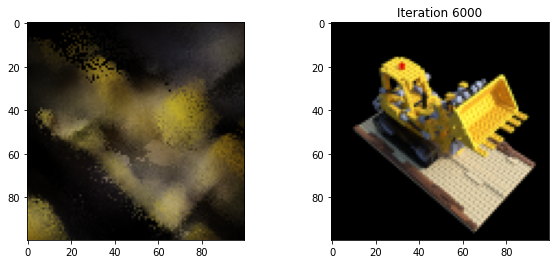

 70%|███████   | 7000/10000 [23:51<10:06,  4.95it/s, loss=0.0235]

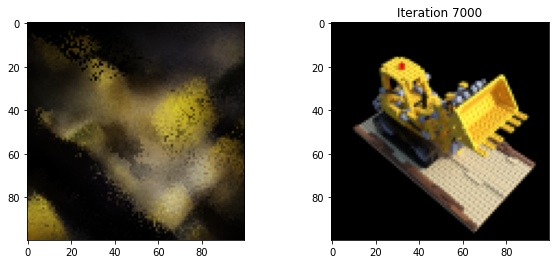

 80%|████████  | 8000/10000 [27:15<06:52,  4.85it/s, loss=0.0214]

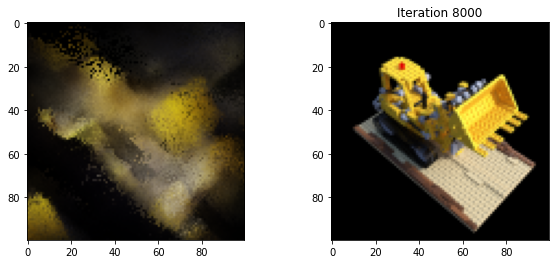

 90%|█████████ | 9000/10000 [30:40<03:19,  5.02it/s, loss=0.0222] 

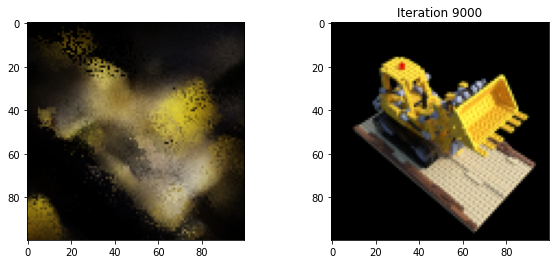

100%|██████████| 10000/10000 [34:05<00:00,  4.89it/s, loss=0.0225]


In [13]:
gamma_x_dim = 3 * 2 * L_x + (3 if include_input else 0)
gamma_d_dim = 3 * 2 * L_d + (3 if include_input else 0)

model = NeRF(gamma_x_dim, gamma_d_dim, num_channels, num_layers, skip)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

progress_bar = tqdm(range(num_iters))

for i in progress_bar:
  # Randomly select one image per iteration
  idx = np.random.randint(images.shape[0])
  images_i = images[idx]
  pose_i = poses[idx]

  rgb_predicted = train_step(h, w, focal_length, pose_i, near, far, N_c, L_x, L_d)

  loss = torch.nn.functional.mse_loss(rgb_predicted, images_i)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  progress_bar.set_postfix({"loss": loss.item()})

  if i % display_every_iter == 0:
    rgb_predicted = train_step(h, w, focal_length, torch.from_numpy(test_pose).to(device), near, far, N_c, L_x, L_d)
    
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.imshow(rgb_predicted.detach().cpu().numpy())

    plt.subplot(122)
    plt.imshow(test_image)
    plt.title(f"Iteration {i}")
    plt.show()